# WSI - Ćwiczenie 2

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest zaimplementowanie algorytmu ewolucyjnego:
- z selekcją turniejową ($k=2$)
- krzyżowaniem jednopunktowym
- mutacją gaussowską
- sukcesją generacyjną

Należy również wykorzystać ten algorytm do znalezienia minimum sumy funkcji $f_1+f_2$, gdzie: 
$$f_1(x_1,y_1)=(x_1^2+y_1-11)^2+(x_1+y_1^2-7)^2$$
$$f_2(x_2,y_2)=2*x_2^2+1.05*x_2^4+\frac{x_2^6}{6}+x_2y_2+y_2^2$$
dla dziedziny $D=[-5,5]\times[-5,5]$, oraz zbadać wpływ dystrybucji populacji początkowej, prawdopodobieństwa mutacji oraz prawdopodobieństwa krzyżowania na współrzędne znalezionych minimów funkcji $f_1$.

## Implementacja algorytmu ewolucyjnego

Do implementacji algorytmu przyjąłem następujące założenia:
- Funkcja celu ma następującą postać: $g(x_1, x_2, y_1, y_2)=f_1(x_1,y_1)+f_2(x_2,y_2)$
- Osobnik jest postaci $(x_1,x_2,y_1,y_2)$
- Kryterium stopu w algorytmie będzie maksymalna liczba pokoleń

Na początku zdefiniuję badane funkcje oraz funkcję celu, będącą ich sumą:

In [2]:
def f1(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def f2(x, y):
    return 2*x**2 + 1.05*x**4 + (1/6)*x**6 + x*y + y**2

def g(x1, x2, y1, y2):
    return f1(x1, y1) + f2(x2, y2)

Pozostałymi hiperparametrami algorytmu będą:
- prawdopodobieństwo mutacji
- siła mutacji 
- prawdopodobieństwo krzyżowania

Przed zaimplementowaniem algorytmu wyznaczę funkcję oceny - wartością zwracaną przez tę funkcję będzie wynik funkcji celu (im mniejszy, tym lepsza ocena). Dodatkowo kara za wyjście poza dziedzinę funkcji przez osobnika to dodanie 1000 do wyniku działania funkcji oceny.

In [3]:
def rate(genes):
    penalty = 0
    domain_conditions = [-5 <= gene <= 5 for gene in genes]
    if not all(domain_conditions):
        penalty += 1000
    return g(genes[0], genes[1], genes[2], genes[3]) + penalty

Następnie zdefiniuję funkcje odpowiedzialne za reprodukcję, krzyżowanie i mutację, z których będzie się składał algorytm ewoulucyjny.

In [4]:
import random
import numpy as np

# Reprodukcja - selekcja turniejowa (turnieje dwuosobnikowe)
def reproduction(population, rating):
    results = []
    for i, individual in enumerate(population):
        opponents = population.copy()
        opponents.pop(i)
        opponent = random.choice(opponents)
        if rating(individual) < rating(opponent):
            results.append(individual)
        else:
            results.append(opponent)
    return results

# Krzyżowanie jednopunktowe - każda para rodziców produkuje dwójkę dzieci
def crossing(population, crossover_prob):
    results = []
    parents_list = population.copy()
    for _ in range(0, len(population) - 1, 2):
        crossover_value = random.uniform(0, 1)
        parent1, parent2 = random.sample(parents_list, 2)
        parents_list.remove(parent1)
        parents_list.remove(parent2)
        if crossover_value < crossover_prob:
            crossing_point = random.randint(1, len(parent1))
            child1, child2 = [
                parent1[:crossing_point] + parent2[crossing_point:],
                parent2[:crossing_point] + parent1[crossing_point:]
            ]
            results.append(child1)
            results.append(child2)
        else:
            results.append(parent1)
            results.append(parent2)
    # Jeśli populacja jest nieparzysta, przenieś rodzica bez pary do wyników
    if len(population) % 2 == 1:
        results.append(parents_list[0])
    return results

# Mutacja gaussowska
def mutation(population, mutation_strength, mutation_prob):
    results = []
    for individual in population:
        mutation_value = random.uniform(0, 1)
        if mutation_value < mutation_prob:
            results.append((individual + mutation_strength * np.random.normal(0, 1, len(individual))).tolist())
        else:
            results.append(individual)
    return results


#### Zaimplementowany algorytm ewolucyjny

In [5]:
def g_minimum(population, rating, crossover_prob, mutation_strength, mutation_prob, max_generations):
    generation = 0
    ratings = [rating(individual) for individual in population]
    best_value = min(ratings)
    best_value_index = ratings.index(best_value)
    best_individual = population[best_value_index]
    while generation < max_generations:
        reproducted = reproduction(population, rating) # Reprodukcja
        crossed = crossing(reproducted, crossover_prob) # Krzyżowanie
        mutated = mutation(crossed, mutation_strength, mutation_prob) # Mutowanie
        # Ocena nowego pokolenia
        new_ratings = [rating(individual) for individual in mutated]
        new_best_value = min(new_ratings)
        new_best_value_index = new_ratings.index(new_best_value)
        new_best_individual = mutated[new_best_value_index]
        if new_best_value < best_value:
            best_value = new_best_value
            best_individual = new_best_individual
        # Sukcesja generacyjna
        population = mutated
        ratings = new_ratings
        generation += 1
    return [best_individual, best_value]

### Szukanie rozwiązania

Przy szukaniu rozwiązania będę wykorzystywał zawsze wykorzystywał populację w postaci 20 osobników o identycznych wartościach genów rosnących od -5 do 5.
Poszukiwania rozpocznę od wartości obu prawdopodobieństw równych 0,5 oraz siły mutacji równej 0,1.
Maksymalna liczba pokoleń początkowo wyniesie 100.

Ze względu na obecność czynnika losowego przy działaniu algorytmu, dla każdego zestawu hiperparametrów algorytm będzie uruchamiany 250 razy, a następnie zwrócone zostaną:
- uśrednione wartości poszczególnych genów osobników w populacji
- średnia otrzymana wartość funkcji celu
- najlepsza (minimalna) otrzymana wartość tej funkcji
- najgorsza otrzymana wartość tej funkcji
- odchylenie standardowe otrzymanych wyników

In [6]:
x1 = np.linspace(-5, 5, 20)
x2 = np.linspace(-5, 5, 20)
y1 = np.linspace(-5, 5, 20)
y2 = np.linspace(-5, 5, 20)
individuals = list(map(list, zip(x1, x2, y1, y2)))
print(f"Populacja początkowa: {individuals}")

def find_min(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations, no_of_experiments):
    individual_results = []
    value_results = [] 
    for i in range(no_of_experiments):
        result = g_minimum(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations)
        individual_results.append(result[0])
        value_results.append(result[1])
    gene_values = list(zip(*individual_results))
    average_individual = [
        sum(gene_values[0]) / len(gene_values[0]),
        sum(gene_values[1]) / len(gene_values[1]),
        sum(gene_values[2]) / len(gene_values[2]),
        sum(gene_values[3]) / len(gene_values[3]),
    ]
    average_value = sum(value_results) / len(value_results)
    print("Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]:", average_individual)
    print("Średnia wartość funkcji celu:", average_value)
    print("Najlepsza znaleziona wartość", min(value_results))
    print("Najgorsza znaleziona wartość", max(value_results))
    print("Odchylenie standardowe wartości osobników:", np.std(value_results))

Populacja początkowa: [[-5.0, -5.0, -5.0, -5.0], [-4.473684210526316, -4.473684210526316, -4.473684210526316, -4.473684210526316], [-3.947368421052632, -3.947368421052632, -3.947368421052632, -3.947368421052632], [-3.4210526315789473, -3.4210526315789473, -3.4210526315789473, -3.4210526315789473], [-2.8947368421052633, -2.8947368421052633, -2.8947368421052633, -2.8947368421052633], [-2.368421052631579, -2.368421052631579, -2.368421052631579, -2.368421052631579], [-1.8421052631578947, -1.8421052631578947, -1.8421052631578947, -1.8421052631578947], [-1.3157894736842106, -1.3157894736842106, -1.3157894736842106, -1.3157894736842106], [-0.7894736842105265, -0.7894736842105265, -0.7894736842105265, -0.7894736842105265], [-0.2631578947368425, -0.2631578947368425, -0.2631578947368425, -0.2631578947368425], [0.2631578947368416, 0.2631578947368416, 0.2631578947368416, 0.2631578947368416], [0.7894736842105257, 0.7894736842105257, 0.7894736842105257, 0.7894736842105257], [1.3157894736842106, 1.31

In [6]:
find_min(individuals, rate, 0.5, 0.1, 0.5, 100, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.854183287004348, -0.0008348665633953353, 1.9244910120144119, 0.004136791540685841]
Średnia wartość funkcji celu: 0.01205773232440195
Najlepsza znaleziona wartość 0.0005550269408349268
Najgorsza znaleziona wartość 0.15839350776349598
Odchylenie standardowe wartości osobników: 0.013902131681042576


Otrzymane rozwiązanie znajduje się w pobliżu prawdziwego minimum, którego wartość wynosi 0 (minimalną wartość funkcji celu sprawdziłem za pomocą programu WolframAlpha).
Spróbuję teraz zmienić wartość prawdopodobieństwa krzyżowania z 0,5 na 0,8 i powtórzyć eksperyment:

In [7]:
find_min(individuals, rate, 0.8, 0.1, 0.5, 100, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.5132495966354744, -5.051408240719828e-05, 1.9450277024223175, 0.0003395929869655468]
Średnia wartość funkcji celu: 0.00860311676871766
Najlepsza znaleziona wartość 0.00038799906969149605
Najgorsza znaleziona wartość 0.07406936183792959
Odchylenie standardowe wartości osobników: 0.007944535828862419


Wyniki delikatnie poprawiły się. Teraz zbadam, czy zwiększenie liczby pokoleń wpłynie na otrzymywane wyniki - ustawię wartość tego hiperparametru na 200:

In [8]:
find_min(individuals, rate, 0.8, 0.1, 0.5, 200, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.7195390267042443, -0.00029459878259310374, 1.9194064932677737, 0.0019775193110726165]
Średnia wartość funkcji celu: 0.0035791919198651006
Najlepsza znaleziona wartość 0.00036201756233851426
Najgorsza znaleziona wartość 0.010704484852046253
Odchylenie standardowe wartości osobników: 0.002152553953998698


Jakość otrzymywanych wyników znacznie wzrosła. Spróbuję jeszcze bardziej je poprzez zmniejszenie siły mutacji do wartości 0.3:

In [9]:
find_min(individuals, rate, 0.8, 0.1, 0.3, 200, 250)

Uśrednione wartości genów osobników w postaci [x1, x2, y1, y2]: [2.5711377162413225, -0.0008220230342739814, 1.9528565315800461, 0.0008819257651802153]
Średnia wartość funkcji celu: 0.0009990328415809982
Najlepsza znaleziona wartość 9.349324845597836e-06
Najgorsza znaleziona wartość 0.008556543652103506
Odchylenie standardowe wartości osobników: 0.000996770176453456


Po wykonaniu tej operacji uzyskałem wyniki, które uważam za zadowalające, dlatego teraz przejdę do badania poszczególnych hiperparametrów.

##### Tabela z otrzymanymi rezultatami

| Prawdopodobieństwo krzyżowania | Siła mutacji | Prawdopodobieństwo mutacji | Liczba pokoleń | Średni wynik | Najlepszy wynik | Najgorszy wynik | Odchylenie standardowe |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0.5 | 0.1 | 0.5 | 100 | 0.0121 | 0.0006 | 0.1584 | 0.0139 |
| 0.8 | 0.1 | 0.5 | 100 | 0.0086 | 0.0004 | 0.0741 | 0.0079 |
| 0.8 | 0.1 | 0.5 | 200 | 0.0036 | 0.0004 | 0.0107 | 0.0022 |
| 0.8 | 0.1 | 0.3 | 200 | 0.0010 | 9.35 * $10^{-6}$ | 0.0086 | 0.0010 |

### Wpływ poszczególnych hiperparametrów na znajdowane minimum funkcji $f_1$

Eksperymenty będę przeprowadzał w następujący sposób:

1. Eksperyment będzie uruchamiany 1000 razy, najlepsze osobniki z każdego uruchomienia będą zapisywane do specjalnej listy
2. Następnie generowany będzie wykres funkcji $f_1$ z zaznaczonymi genami $x_1$, $y_1$ każdego osobnika z wcześniej zdefiniowanej listy 
3. Dodatkowo przy badaniu wpływu wartości prawdopodobieństwa mutacji oraz krzyżowania generowany będzie wykres porównujący precyzję otrzymywanych wyników (im wartość funkcji $f_1$ bliższa zeru, tym lepiej)

Algorytm będzie uruchamiany z następującymi hiperparametrami (chyba że jeden z nich będzie badany):
- prawdopodobieństwo krzyżowania: 0,8
- siła mutacji: 1,5
- liczba pokoleń: 100

In [7]:
import matplotlib.pyplot as plt

def plot_results(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations, no_of_experiments):
    best_genes = []
    for _ in range(no_of_experiments):
        experiment = g_minimum(population, rate, crossover_prob, mutation_strength, mutation_prob, max_generations)
        best_genes.append([experiment[0][0], experiment[0][2]]) # dodaj tylko wartości genów x1 i y1

    # Wykres
    x1 = np.linspace(-5, 5, 20)
    y1 = np.linspace(-5, 5, 20)
    X1, Y1 = np.meshgrid(x1, y1)
    z = f1(X1, Y1)
    plt.contourf(X1, Y1, z, 50)
    plt.colorbar()
    plt.scatter(*zip(*best_genes), color="red", s=1)
    plt.xlabel("x1")
    plt.ylabel("y1")
    plt.show()


#### Dystrybucja populacji początkowej

Przed rozpoczęciem eksperymentów zdefiniuję dwie populacje osobników:
- z jednorodną dystrybucją po całym obszarze dziedziny funkcji z odstępami wynoszącymi 0.5
- z dystrybucją zgodną z rozkładem normalnym wokół $x_1=-0.3, y_1=-0.9$ dla $f_1$ oraz dowolnie przyjętą dla $x_2, y_2$ (w moim przypadku jest to rozkład wokół zera).

Dodatkowo za wartość hiperparametru prawdopodobieństwa mutacji przyjąłem wartość 0.1.

In [8]:
# Jednorodna dystrybucja
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
X, Y = np.meshgrid(x, y)
even_individuals = list(map(list, zip(X.flatten(), X.flatten(), Y.flatten(), Y.flatten())))

# Rozkład normalny
distributed_individuals = []
for _ in range(100):
    distributed_individuals.append([
        np.random.normal(-0.3, 1),
        np.random.normal(0, 1),
        np.random.normal(-0.9, 1),
        np.random.normal(0, 1)
    ])

##### Dystrybucja jednorodna po obszarze

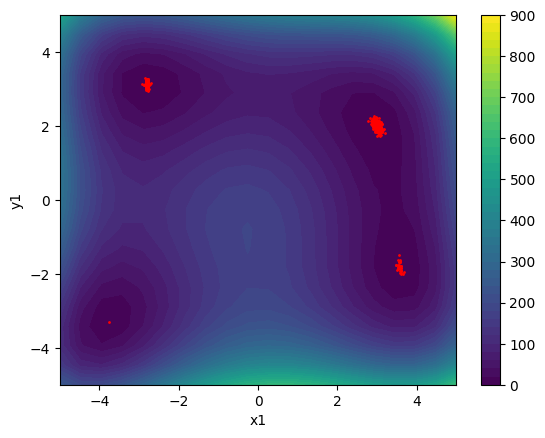

In [73]:
plot_results(even_individuals, rate, 0.8, 1.5, 0.1, 100, 1000)

Najpopularniejszym minimum było to znajdujące się w pobliżu $x_1=3,y_1=2$. Można również zauważyć, że wszystkie eksperymenty z wyjątkiem jednego kończyły się w trzech z czterech minimów - może to wskazywać na to, że prawdopodobnie przestrzeń nie jest przeszukiwana w równomierny sposób.

##### Dystrybucja zgodna z rozkładem normalnym

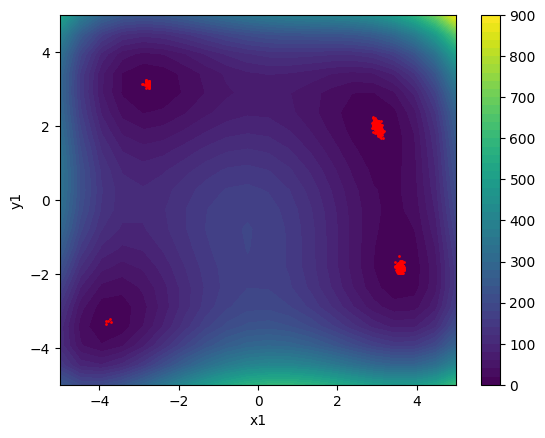

In [74]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.1, 100, 1000)

W przypadku dystrybucji populacji zgodnie z rozkładem normalnym wokół $x_1=-0.3,\;y_1=-0.9$ algorytm na pierwszy rzut oka bardziej równomiernie zbiegał do wszystkich minimów.

Porównam teraz wartości funkcji dla otrzymywanych współrzędnych w celu oszacowania precyzji otrzymywanych wyników:

In [78]:
def population_experiments():
    even_results = []
    distributed_results = []
    for _ in range(1000):
        even_experiment = g_minimum(even_individuals, rate, 0.8, 1.5, 0.1, 100)
        even_results.append(f1(even_experiment[0][0], even_experiment[0][2]))
        distributed_experiment = g_minimum(distributed_individuals, rate, 0.8, 1.5, 0.1, 100)
        distributed_results.append(f1(distributed_experiment[0][0], distributed_experiment[0][2]))
    even_average = sum(even_results) / len(even_results)
    distributed_average = sum(distributed_results) / len(distributed_results)
    even_best = min(even_results)
    distributed_best = min(distributed_results)
    even_deviation = np.std(even_results)
    distributed_deviation = np.std(distributed_results)

    print("Uśrednione wartości funkcji f1 dla populacji o jednorodnym rozkładzie:", even_average)
    print("Uśrednione wartości funkcji f1 dla populacji o rozkładzie normalnym:", distributed_average)
    print("Najlepsze znalezione wartości dla populacji o jednorodnym rozkładzie:", even_best)
    print("Najlepsze znalezione wartości dla populacji o rozkładzie normalnym:", distributed_best)
    print("Odchylenie standardowe wartości funkcji f1 dla populacji o jednorodnym rozkładzie:", even_deviation)
    print("Odchylenie standardowe wartości funkcji f1 dla populacji o rozkładzie normalnym:", distributed_deviation)

population_experiments()

Uśrednione wartości funkcji f1 dla populacji o jednorodnym rozkładzie: 0.20003502922233143
Uśrednione wartości funkcji f1 dla populacji o rozkładzie normalnym: 0.15793678168470954
Najlepsze znalezione wartości dla populacji o jednorodnym rozkładzie: 0.0001789369761834403
Najlepsze znalezione wartości dla populacji o rozkładzie normalnym: 0.0002063425751393014
Odchylenie standardowe wartości funkcji f1 dla populacji o jednorodnym rozkładzie: 0.24738451068252387
Odchylenie standardowe wartości funkcji f1 dla populacji o rozkładzie normalnym: 0.18185910465066454


Populacja z rozkładem jednorodnym otrzymywała bardziej precyzyjne wyniki. Z tego powodu w następnych eksperymentach będzie ona używana jako populacja początkowa.

#### Prawdopodobieństwo mutacji

Będę badał wartości od 0.01 do 0.5 w odstępach wynoszących 0.05.

##### Wartość 0.01

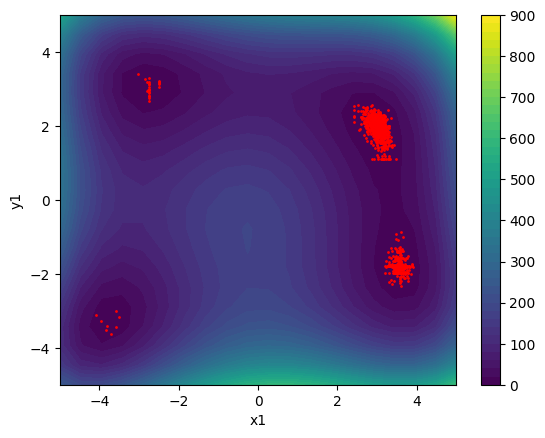

In [76]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.01, 100, 1000)

##### Wartość 0.05

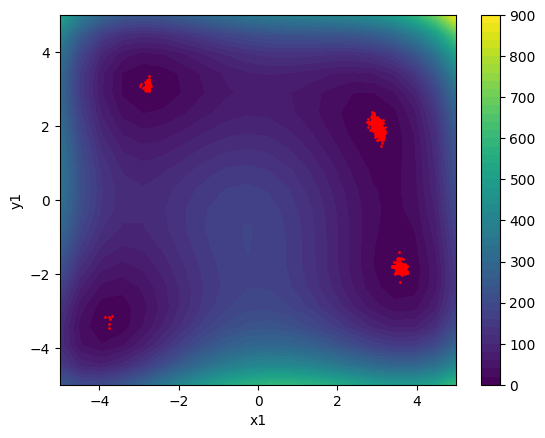

In [79]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.05, 100, 1000)

##### Wartość 0.1

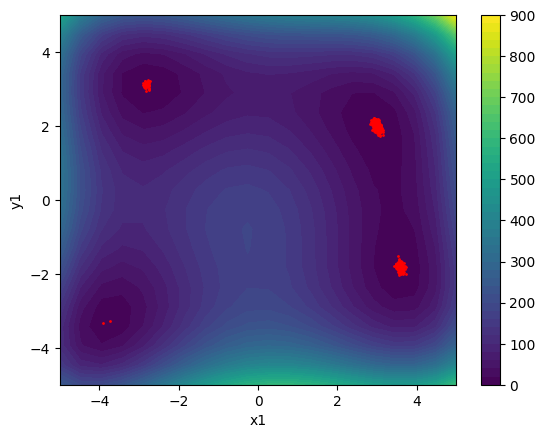

In [80]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.1, 100, 1000)

##### Wartość 0.15

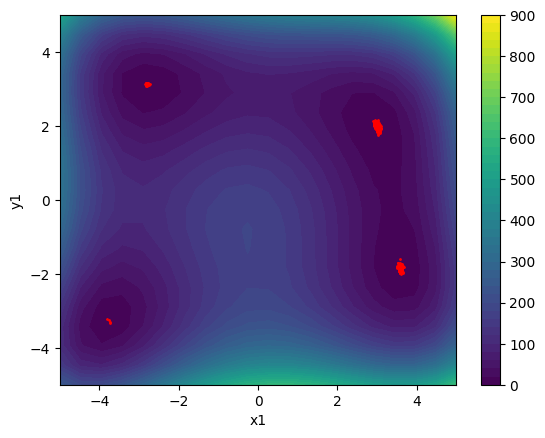

In [81]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.15, 100, 1000)

##### Wartość 0.2

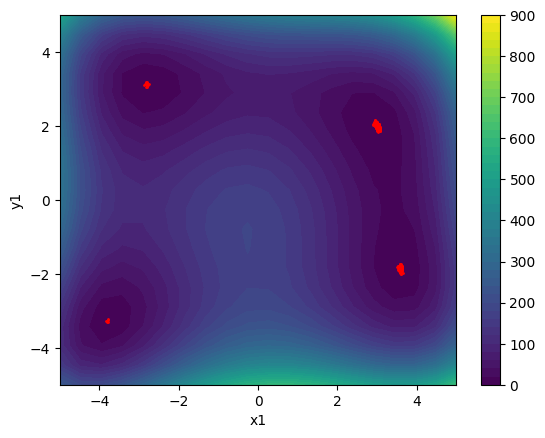

In [82]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.2, 100, 1000)

##### Wartość 0.25

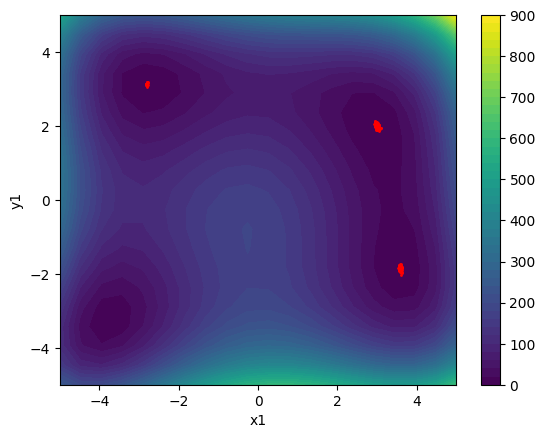

In [83]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.25, 100, 1000)

##### Wartość 0.3

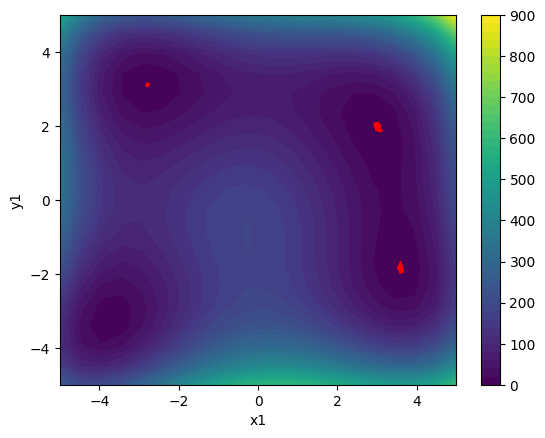

In [84]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.3, 100, 1000)

##### Wartość 0.35

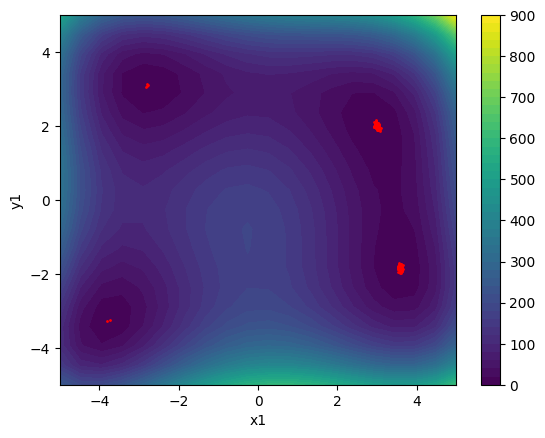

In [85]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.35, 100, 1000)

##### Wartość 0.4

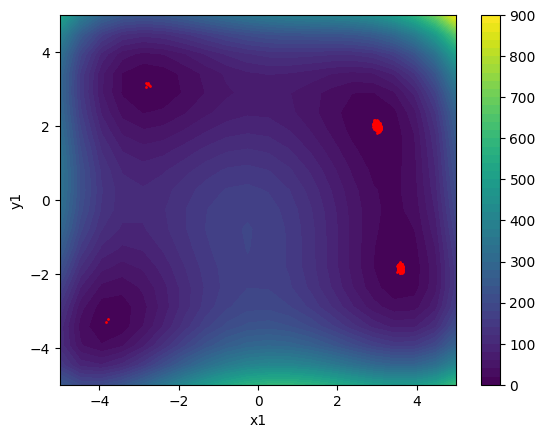

In [86]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.4, 100, 1000)

##### Wartość 0.45

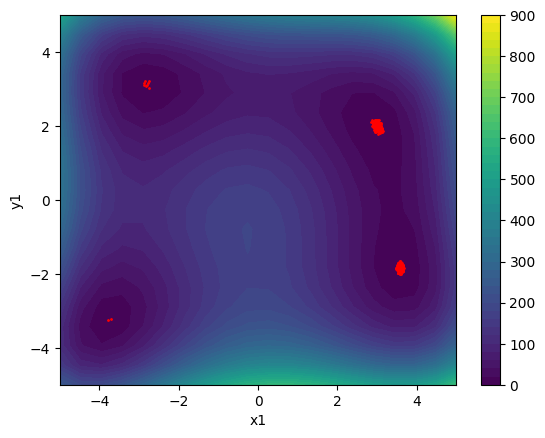

In [87]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.45, 100, 1000)

##### Wartość 0.5

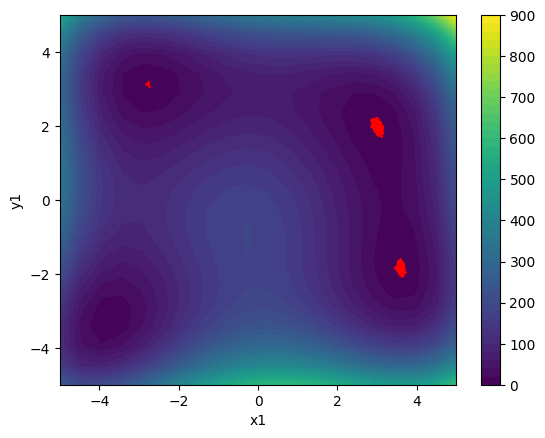

In [88]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.5, 100, 1000)

##### Porównanie otrzymywanych wartości funkcji $f_1$

Aby przeprowadzić ten eksperyment, zdefiniuję funkcję, która uruchomi algorytm ewolucyjny dla zbadanych wyżej wartości hiperparametru, zapisze otrzymaną średnią minimalną wartość najlepszą znalezioną wartość oraz odchylenie standardowe wartości funkcji $f_1$ dla każdej z nich, a następnie narysuje wykres porównujący je.

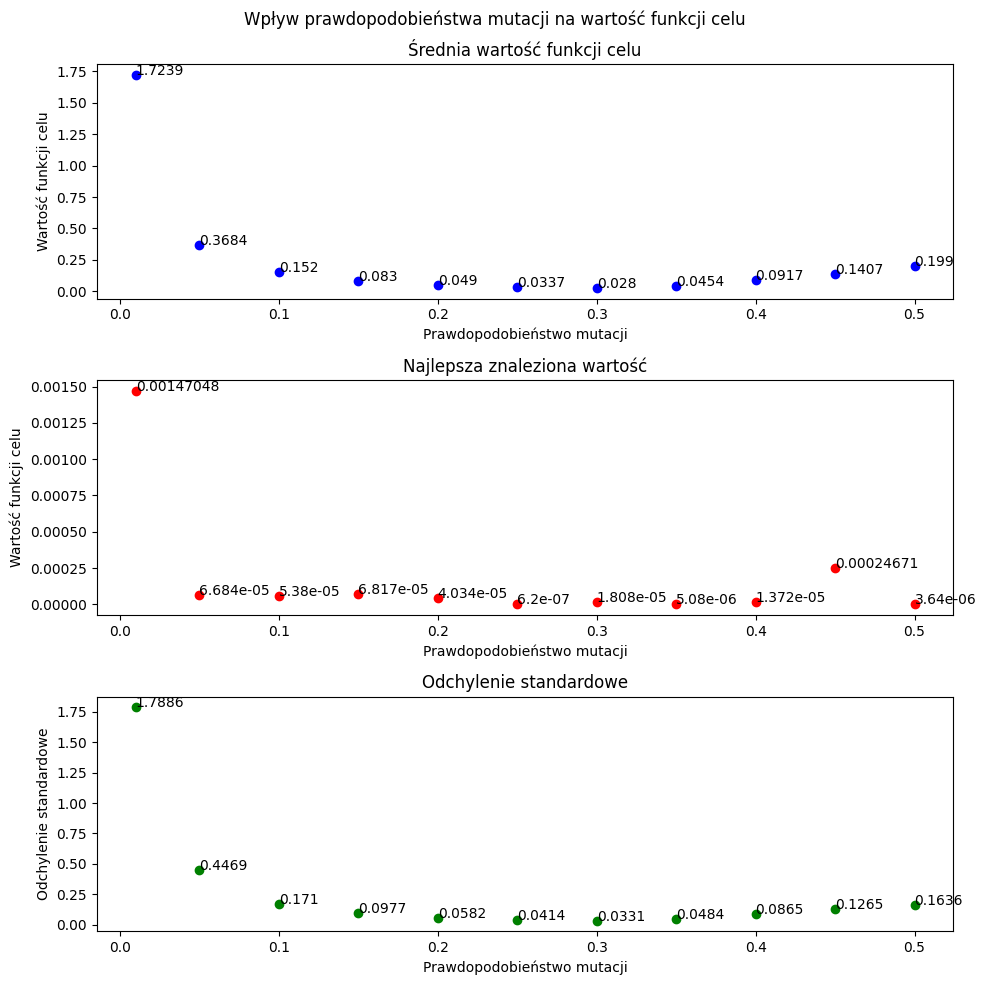

In [89]:
def mutation_experiments():
    # Ze względu na niedokładność operacji dodawania liczb zmiennoprzecinkowych
    # wartości prawdopodobieństw są zaokrąglane do 2 miejsc po przecinku
    steps = [0.01] + [round(x, 2) for x in np.arange(0.05, 0.51, 0.05)]
    current = 0.01 
    plot_values = []
    plot_best = []
    plot_deviation = []
    while current < 0.51:
        experiment_values = []
        for _ in range(1000):
            result = g_minimum(distributed_individuals, rate, 0.8, 1.5, round(current, 2), 100)
            experiment_values.append(f1(result[0][0], result[0][2]))
        plot_values.append(sum(experiment_values) / len(experiment_values))
        plot_best.append(min(experiment_values))
        plot_deviation.append(np.std(experiment_values))
        if current == 0.01:
            current = 0.05
        else:
            current += 0.05

    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.suptitle("Wpływ prawdopodobieństwa mutacji na wartość funkcji celu")
    axs[0].scatter(steps, plot_values, color="blue")
    axs[0].set_title("Średnia wartość funkcji celu")
    axs[0].set_ylabel("Wartość funkcji celu")
    axs[0].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_values):
        axs[0].annotate(round(txt, 4), (steps[i], plot_values[i]))
    axs[1].scatter(steps, plot_best, color="red")
    axs[1].set_title("Najlepsza znaleziona wartość")
    axs[1].set_ylabel("Wartość funkcji celu")
    axs[1].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_best):
        axs[1].annotate(round(txt, 8), (steps[i], plot_best[i]))
    axs[2].scatter(steps, plot_deviation, color="green")
    axs[2].set_title("Odchylenie standardowe")
    axs[2].set_ylabel("Odchylenie standardowe")
    axs[2].set_xlabel("Prawdopodobieństwo mutacji")
    for i, txt in enumerate(plot_deviation):
        axs[2].annotate(round(txt, 4), (steps[i], plot_deviation[i]))
    plt.tight_layout()
    plt.show()

mutation_experiments()    

##### Wnioski

Zmiany wartości prawdopodobieństwa mutacji do wartości 0.3 wpływały pozytywnie na otrzymywane rezultaty - współrzędne znajdowały się coraz bliżej prawdziwych minimów, co można zauważyć na podstawie średnich otrzymywanych wyników funkcji $f_1$ po uruchamianiu eksperymentów. Dla wartości wyższych funkcja wyniki były stopniowo coraz bardziej nieprecyzyjne, jednak nie była to aż tak duża różnica jak np. między wartościami parametrów 0.01, 0.05 i 0.1. Można również zauważyć, że dla rosnących wartości hiperparametru coraz mniej wartości współrzędnych znajdowało się w pobliżu minimum funkcji w okolicach $x_1\approx-4,y_1\approx-3$ - czasem występowała sytuacja, że nie było tam żadnych współrzędnych, jednak nie było to zjawisko występujące w regularny sposób.

#### Prawdopodobieństwo krzyżowania

Będę badał wartości od 0.8 do 0.95 w odstępach wynoszących 0.01. Dodatkowo używana przy tych eksperymentach będzie wartość prawdopodobieństwa mutacji wynosząca 0.3.

##### Wartość 0.8

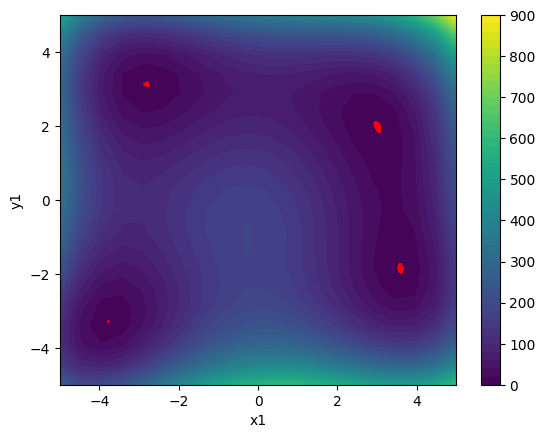

In [90]:
plot_results(distributed_individuals, rate, 0.8, 1.5, 0.3, 100, 1000)

##### Wartość 0.81

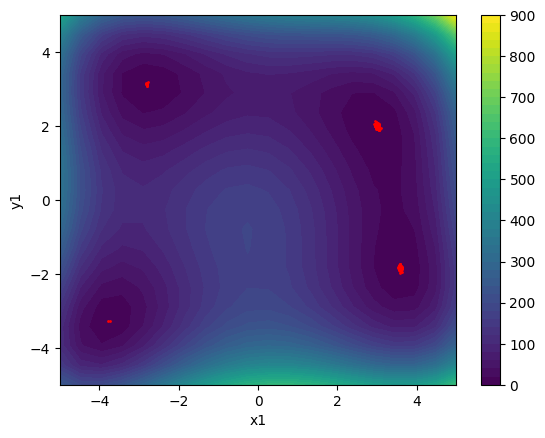

In [91]:
plot_results(distributed_individuals, rate, 0.81, 1.5, 0.3, 100, 1000)

##### Wartość 0.82

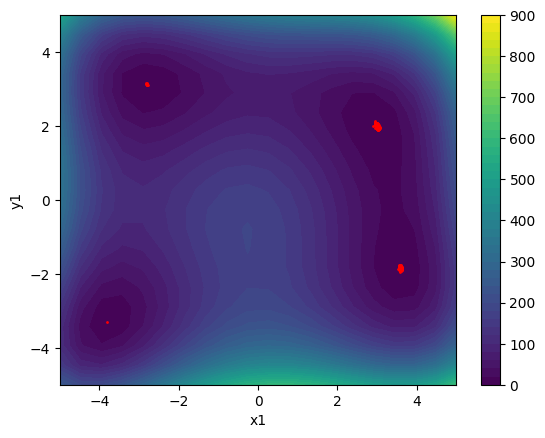

In [92]:
plot_results(distributed_individuals, rate, 0.82, 1.5, 0.3, 100, 1000)

##### Wartość 0.83

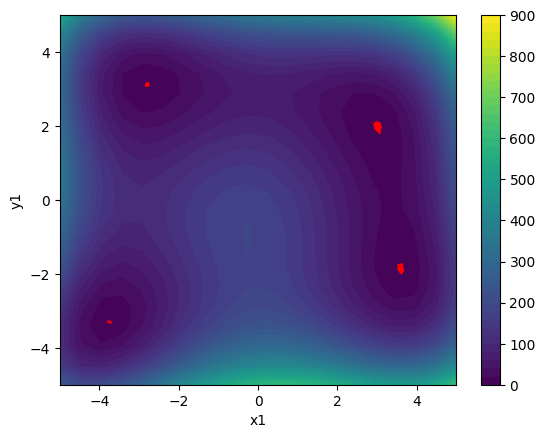

In [93]:
plot_results(distributed_individuals, rate, 0.83, 1.5, 0.3, 100, 1000)

##### Wartość 0.84

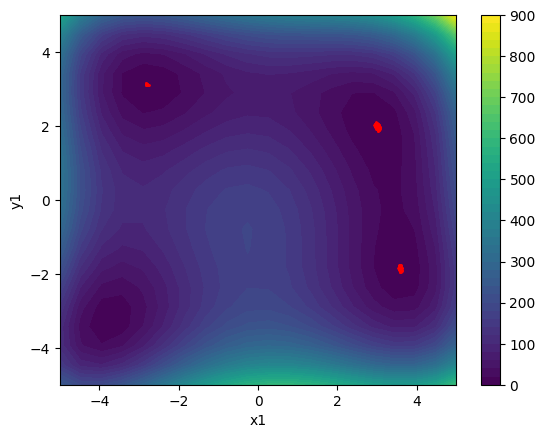

In [94]:
plot_results(distributed_individuals, rate, 0.84, 1.5, 0.3, 100, 1000)

##### Wartość 0.85

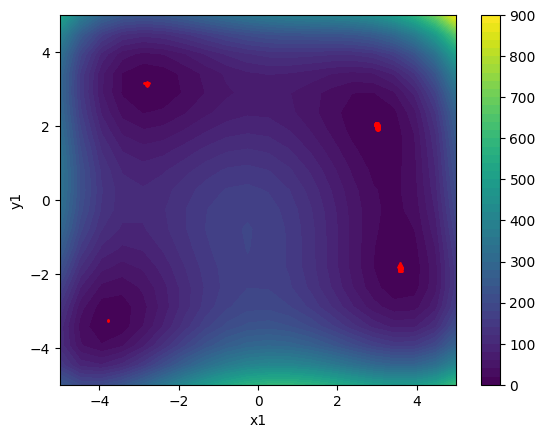

In [95]:
plot_results(distributed_individuals, rate, 0.85, 1.5, 0.3, 100, 1000)

##### Wartość 0.86

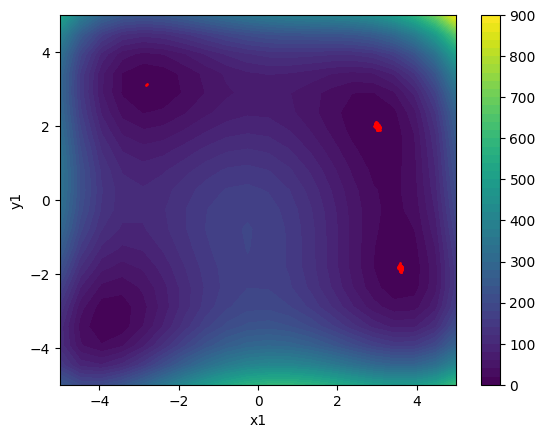

In [96]:
plot_results(distributed_individuals, rate, 0.86, 1.5, 0.3, 100, 1000)

##### Wartość 0.87

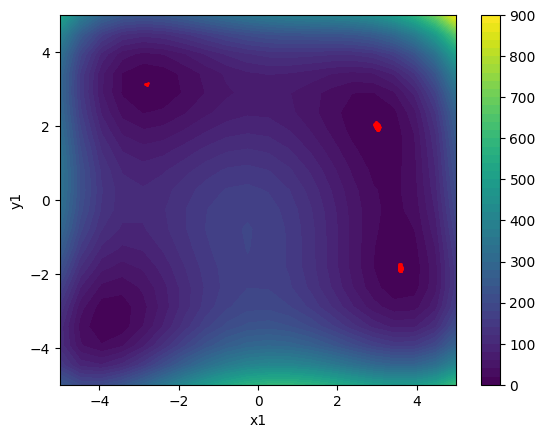

In [97]:
plot_results(distributed_individuals, rate, 0.87, 1.5, 0.3, 100, 1000)

##### Wartość 0.88

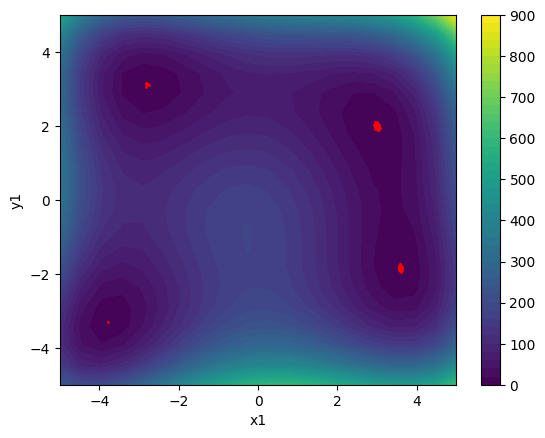

In [98]:
plot_results(distributed_individuals, rate, 0.88, 1.5, 0.3, 100, 1000)

##### Wartość 0.89

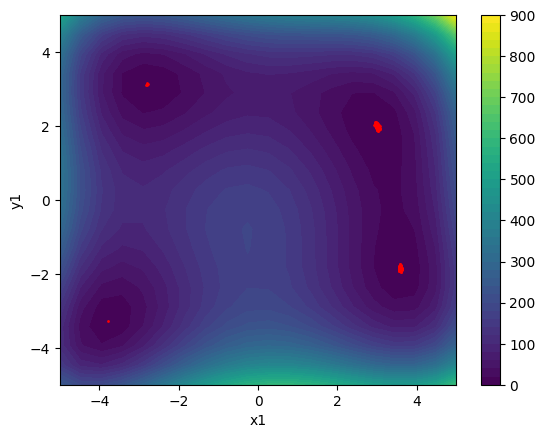

In [99]:
plot_results(distributed_individuals, rate, 0.89, 1.5, 0.3, 100, 1000)

##### Wartość 0.9

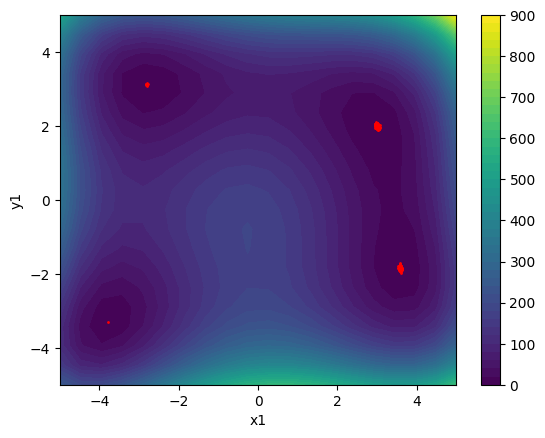

In [100]:
plot_results(distributed_individuals, rate, 0.9, 1.5, 0.3, 100, 1000)

##### Wartość 0.91

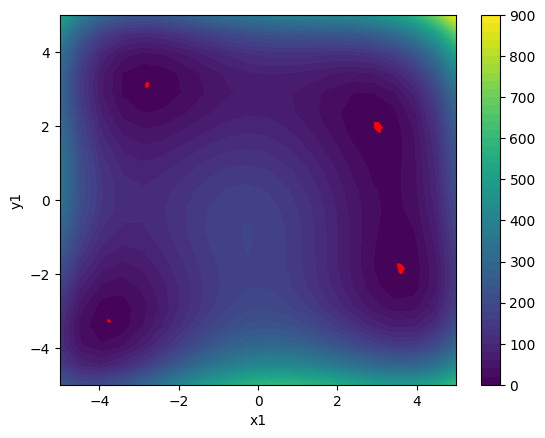

In [101]:
plot_results(distributed_individuals, rate, 0.91, 1.5, 0.3, 100, 1000)

##### Wartość 0.92

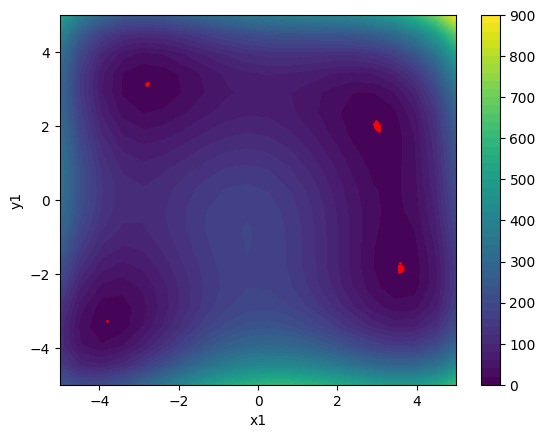

In [102]:
plot_results(distributed_individuals, rate, 0.92, 1.5, 0.3, 100, 1000)

##### Wartość 0.93

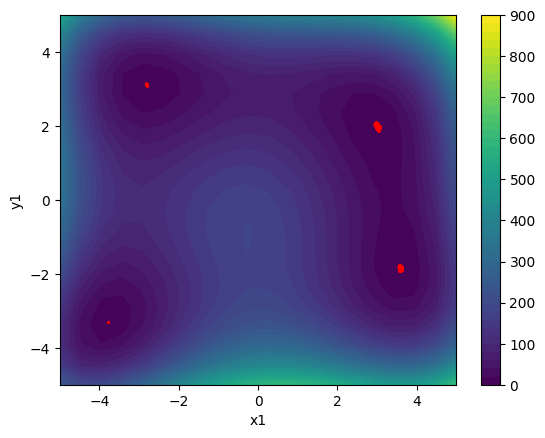

In [103]:
plot_results(distributed_individuals, rate, 0.93, 1.5, 0.3, 100, 1000)

##### Wartość 0.94

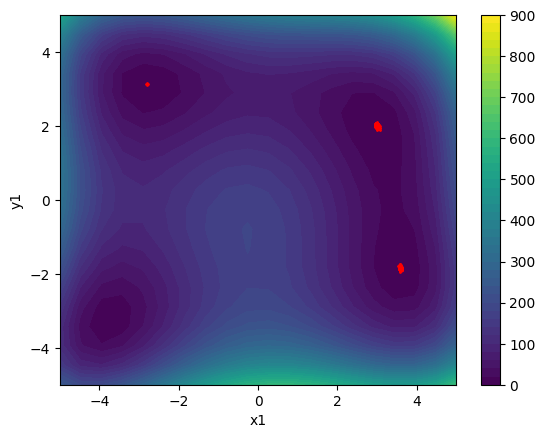

In [104]:
plot_results(distributed_individuals, rate, 0.94, 1.5, 0.3, 100, 1000)

##### Wartość 0.95

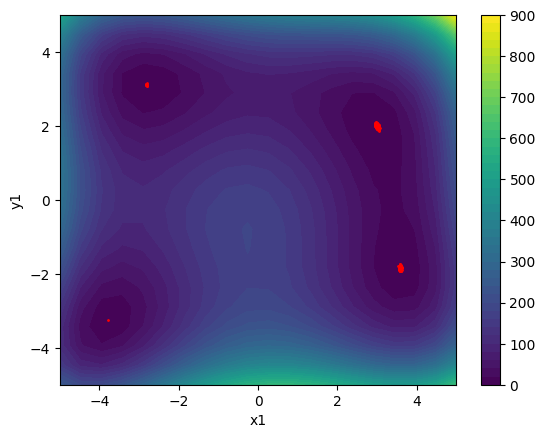

In [105]:
plot_results(distributed_individuals, rate, 0.95, 1.5, 0.3, 100, 1000)

##### Porównanie otrzymywanych wartości funkcji $f_1$

Aby przeprowadzić ten eksperyment, zdefiniuję funkcję, która uruchomi algorytm ewolucyjny dla zbadanych wyżej wartości hiperparametru, zapisze otrzymaną średnią minimalną wartość najlepszą znalezioną wartość oraz odchylenie standardowe wartości funkcji $f_1$ dla każdej z nich, a następnie narysuje wykres porównujący je.


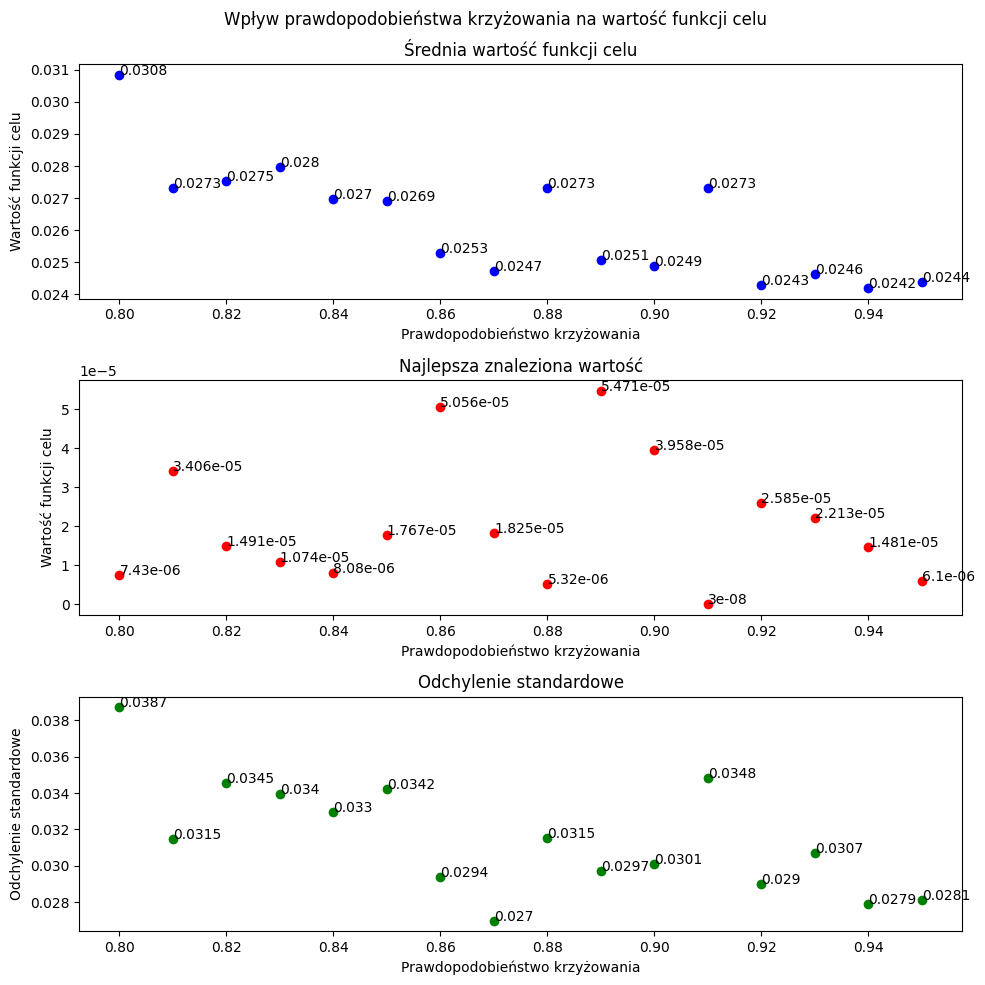

In [106]:
def crossover_experiments():
    # Ze względu na niedokładność operacji dodawania liczb zmiennoprzecinkowych
    # wartości prawdopodobieństw są zaokrąglane do 2 miejsc po przecinku
    steps = [round(x, 2) for x in np.arange(0.8, 0.951, 0.01)]
    current = 0.8 
    plot_values = []
    plot_best = []
    plot_deviation = []
    while current < 0.951:
        experiment_values = []
        for _ in range(1000):
            result = g_minimum(distributed_individuals, rate, round(current, 2), 1.5, 0.3, 100)
            experiment_values.append(f1(result[0][0], result[0][2]))
        plot_values.append(sum(experiment_values) / len(experiment_values))
        plot_best.append(min(experiment_values))
        plot_deviation.append(np.std(experiment_values))
        current += 0.01

    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.suptitle("Wpływ prawdopodobieństwa krzyżowania na wartość funkcji celu")
    axs[0].scatter(steps, plot_values, color="blue")
    axs[0].set_title("Średnia wartość funkcji celu")
    axs[0].set_ylabel("Wartość funkcji celu")
    axs[0].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_values):
        axs[0].annotate(round(txt, 4), (steps[i], plot_values[i]))
    axs[1].scatter(steps, plot_best, color="red")
    axs[1].set_title("Najlepsza znaleziona wartość")
    axs[1].set_ylabel("Wartość funkcji celu")
    axs[1].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_best):
        axs[1].annotate(round(txt, 8), (steps[i], plot_best[i]))
    axs[2].scatter(steps, plot_deviation, color="green")
    axs[2].set_title("Odchylenie standardowe")
    axs[2].set_ylabel("Odchylenie standardowe")
    axs[2].set_xlabel("Prawdopodobieństwo krzyżowania")
    for i, txt in enumerate(plot_deviation):
        axs[2].annotate(round(txt, 4), (steps[i], plot_deviation[i]))
    plt.tight_layout()
    plt.show()

crossover_experiments()

##### Wnioski

Zmiany hiperparametru odpowiedzialnego za prawdopodobieństwo krzyżowania nie wpływały znacząco na rozkład współrzędnych znajdowanych minimów funkcji $f_1$. Pondato dodatkowy eksperyment w postaci badania otrzymanej wartości minimum funkcji nie wykazał żadnych trendów związanych ze zmianą hiperparametru.

### Działanie poszczególnych etapów optymalizacji

W celu porównania działania poszczególnych etapów optymalizacji uruchomię algorytm ewolucyjny dla 5 pokoleń i populacji 100 osobników rozłożonych jednorodnie po dziedzinie funkcji. Dla każdego pokolenia generowane będą cztery wykresy dystrybucji populacji:
- populacji początkowej pokolenia
- populacji po selekcji turniejowej
- populacji po krzyżowaniu
- populacji po mutacji

W sumie będzie to 20 wykresów dla każdej z dwóch funkcji wchodzących w skład funkcji celu.

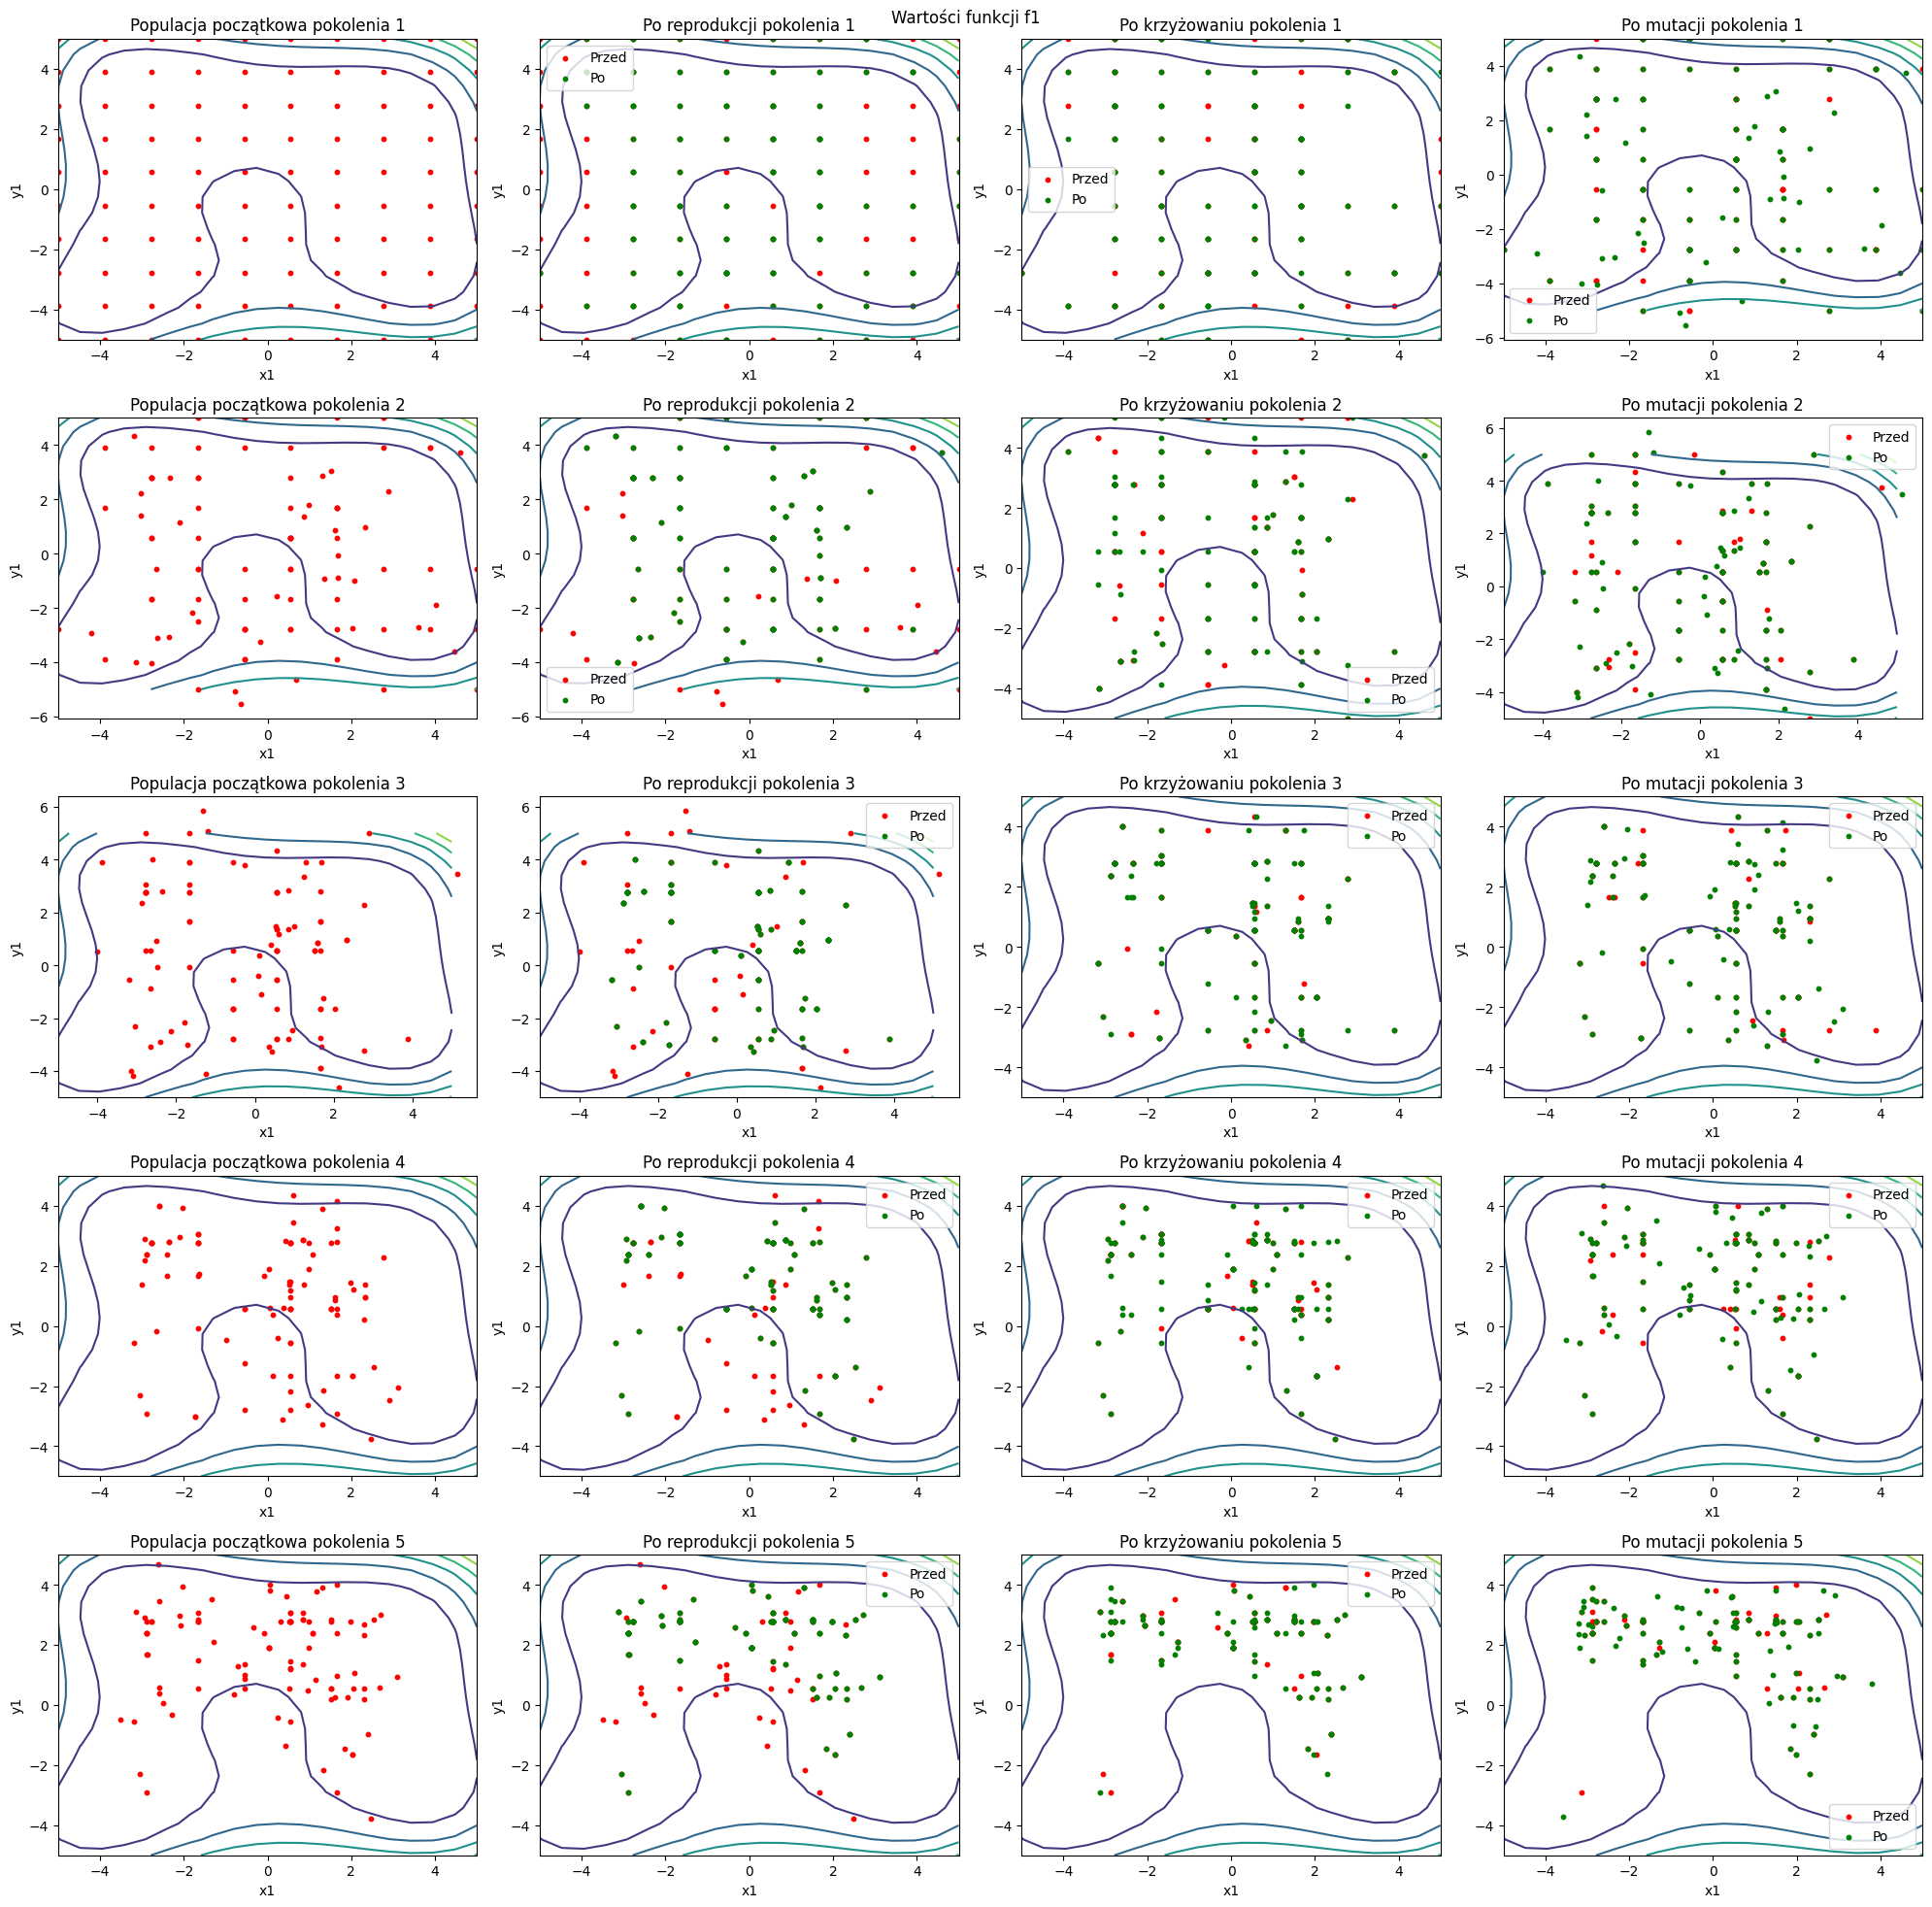

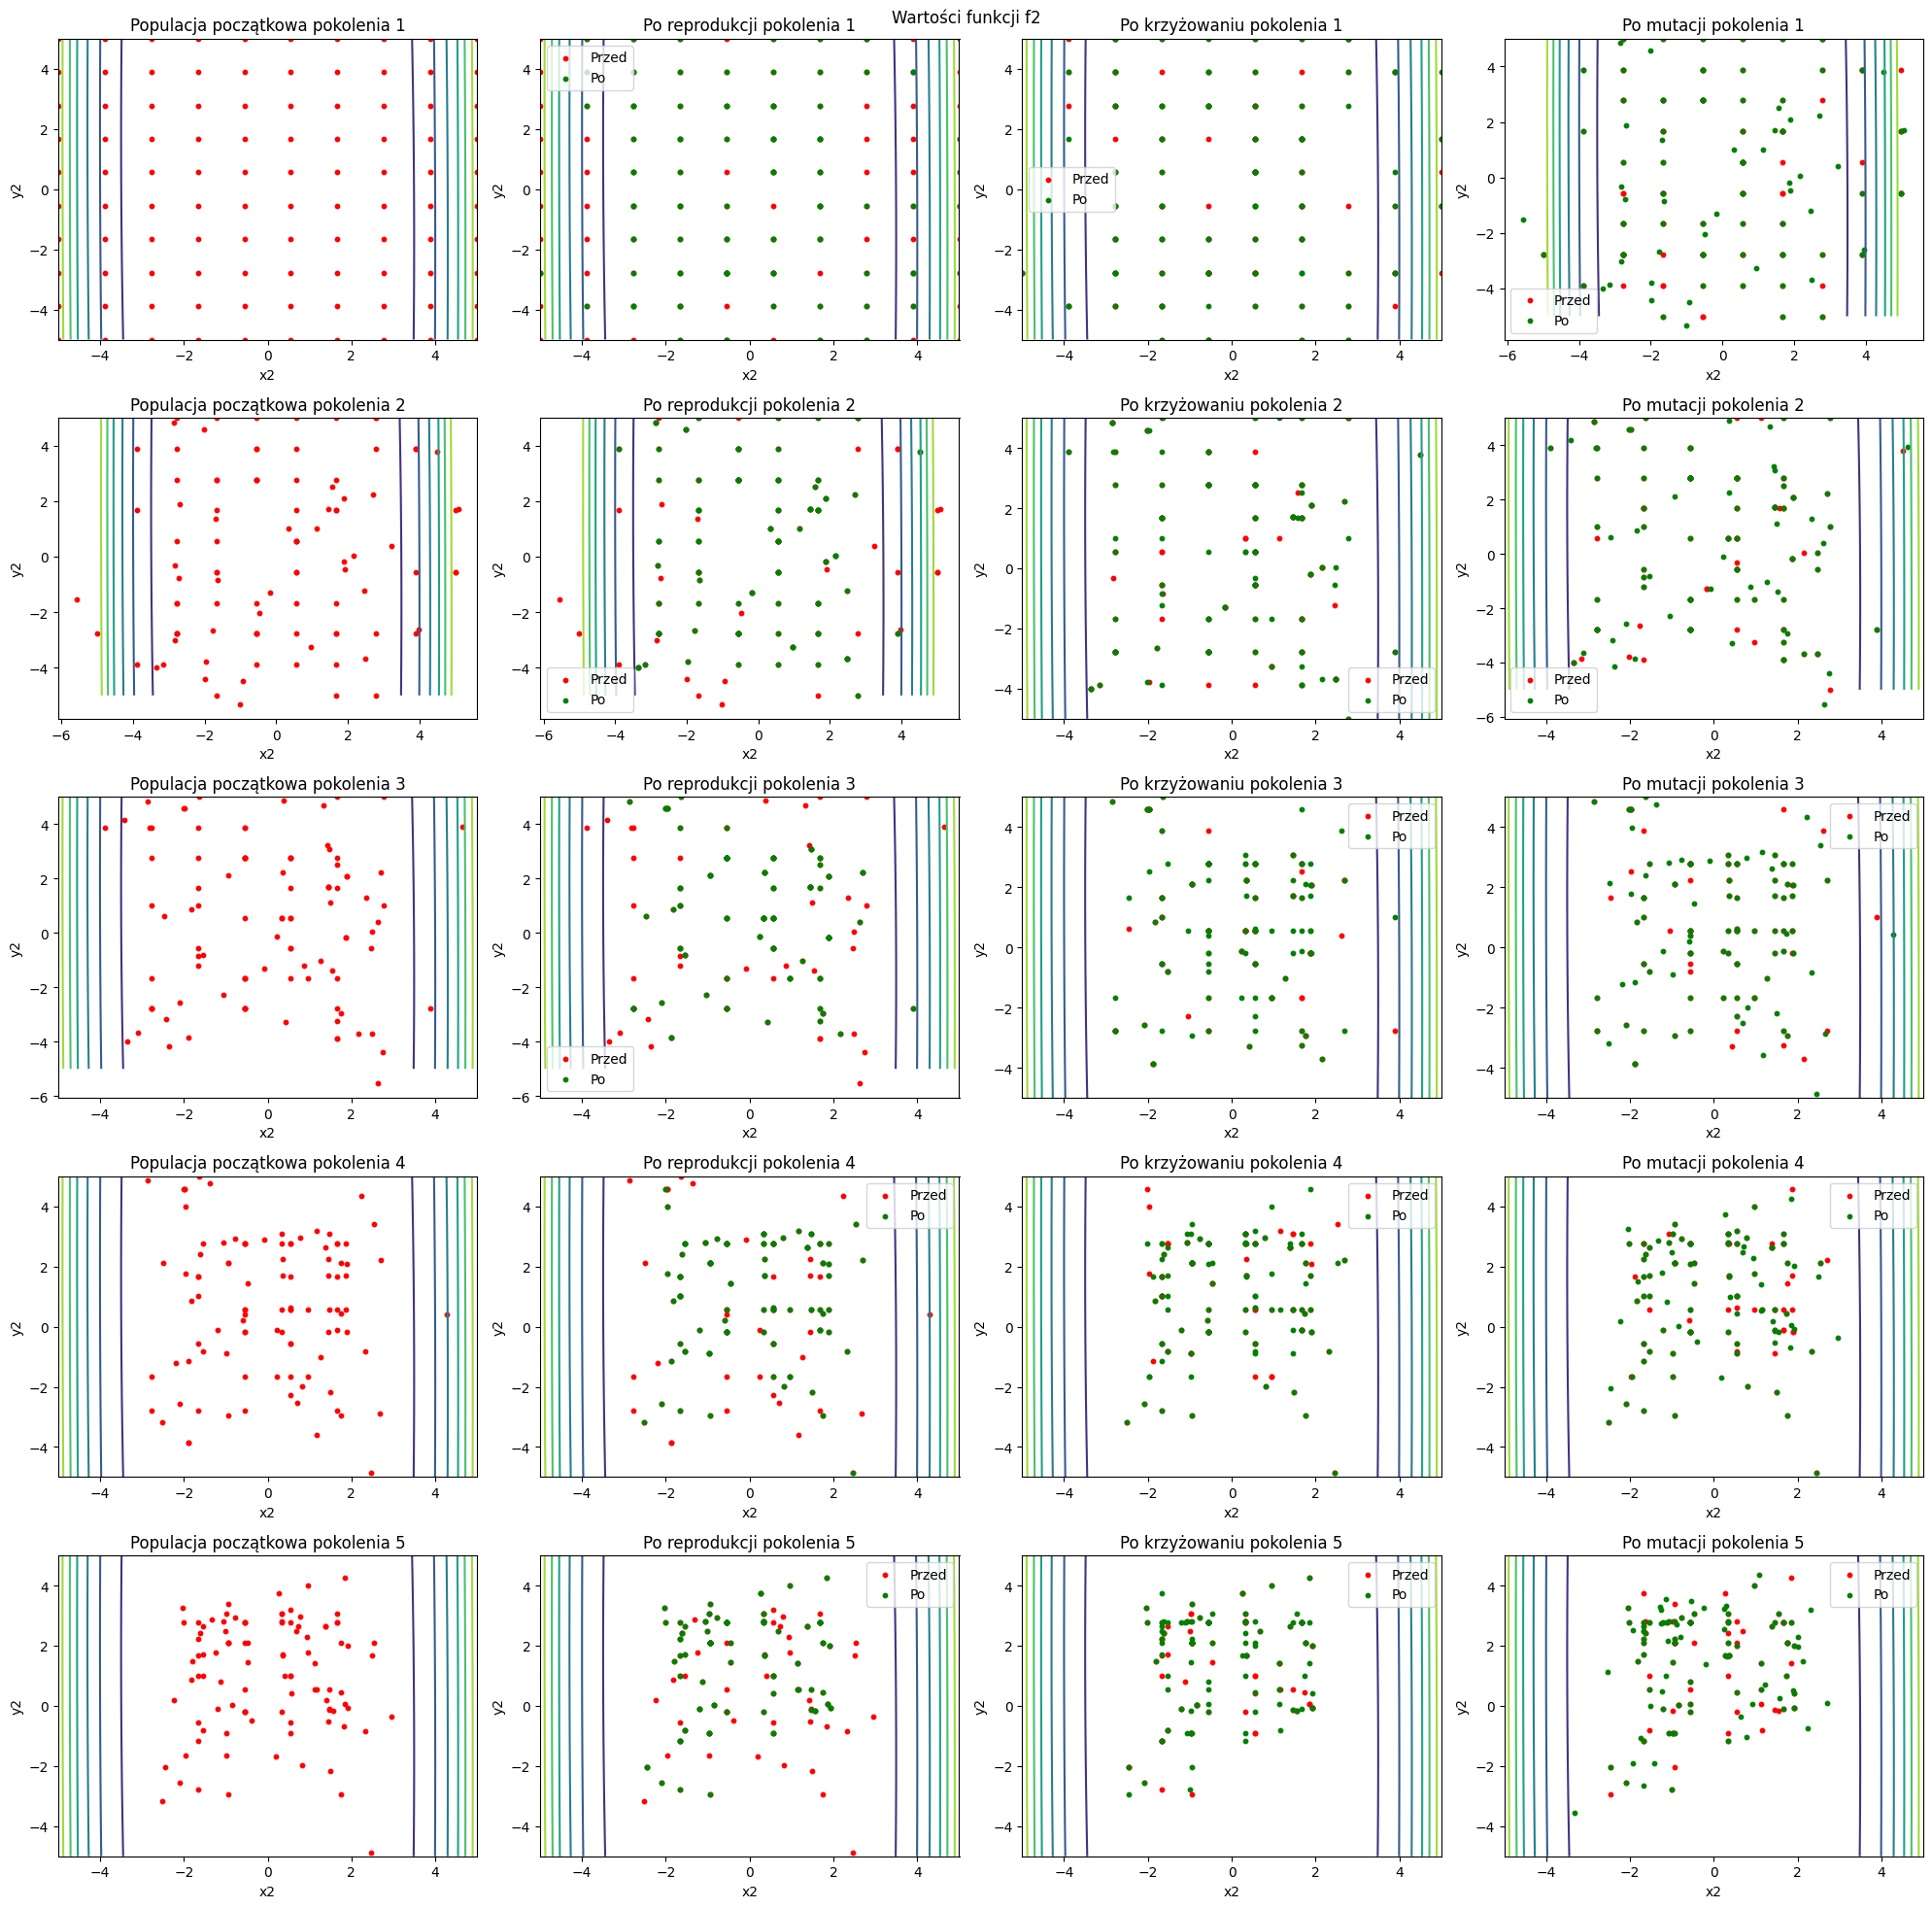

In [33]:
def plot_optimization(population):
    x1 = np.linspace(-5, 5, 20)
    x2 = np.linspace(-5, 5, 20)
    y1 = np.linspace(-5, 5, 20)
    y2 = np.linspace(-5, 5, 20)
    X1, Y1 = np.meshgrid(x1, y1)
    X2, Y2 = np.meshgrid(x2, y2)
    z1 = f1(X1, Y1)
    z2 = f2(X2, Y2)
    fig1, axs1 = plt.subplots(5, 4, figsize=(20, 20))
    fig1.suptitle("Wartości funkcji f1")
    fig2, axs2 = plt.subplots(5, 4, figsize=(20, 20))
    fig2.suptitle("Wartości funkcji f2")
    for i in range(5):
        reproducted = reproduction(population, rate)
        crossed = crossing(reproducted, 0.8)
        mutated = mutation(crossed, 0.5, 0.3)
        axs1[i][0].contour(X1, Y1, z1)
        axs2[i][0].contour(X2, Y2, z2)
        axs1[i][0].set_title(f"Populacja początkowa pokolenia {i + 1}")
        axs2[i][0].set_title(f"Populacja początkowa pokolenia {i + 1}")
        axs1[i][0].scatter([individual[0] for individual in population], [individual[2] for individual in population], color="red", s=10)
        axs2[i][0].scatter([individual[1] for individual in population], [individual[3] for individual in population], color="red", s=10)
        axs1[i][0].set_xlabel("x1")
        axs1[i][0].set_ylabel("y1")
        axs2[i][0].set_xlabel("x2")
        axs2[i][0].set_ylabel("y2")
        axs1[i][1].contour(X1, Y1, z1)
        axs2[i][1].contour(X2, Y2, z2)
        axs1[i][1].set_title(f"Po reprodukcji pokolenia {i + 1}")
        axs2[i][1].set_title(f"Po reprodukcji pokolenia {i + 1}")
        axs1[i][1].scatter([individual[0] for individual in population], [individual[2] for individual in population], color="red", s=10, label="Przed")
        axs2[i][1].scatter([individual[1] for individual in population], [individual[3] for individual in population], color="red", s=10, label="Przed")
        axs1[i][1].scatter([individual[0] for individual in reproducted], [individual[2] for individual in reproducted], color="green", s=10, label="Po")
        axs2[i][1].scatter([individual[1] for individual in reproducted], [individual[3] for individual in reproducted], color="green", s=10, label="Po")
        axs1[i][1].legend()
        axs2[i][1].legend()
        axs1[i][1].set_xlabel("x1")
        axs1[i][1].set_ylabel("y1")
        axs2[i][1].set_xlabel("x2")
        axs2[i][1].set_ylabel("y2")
        axs1[i][2].contour(X1, Y1, z1)
        axs2[i][2].contour(X2, Y2, z2)
        axs1[i][2].set_title(f"Po krzyżowaniu pokolenia {i + 1}")
        axs2[i][2].set_title(f"Po krzyżowaniu pokolenia {i + 1}")
        axs1[i][2].scatter([individual[0] for individual in reproducted], [individual[2] for individual in reproducted], color="red", s=10, label="Przed")
        axs2[i][2].scatter([individual[1] for individual in reproducted], [individual[3] for individual in reproducted], color="red", s=10, label="Przed")
        axs1[i][2].scatter([individual[0] for individual in crossed], [individual[2] for individual in crossed], color="green", s=10, label="Po")
        axs2[i][2].scatter([individual[1] for individual in crossed], [individual[3] for individual in crossed], color="green", s=10, label="Po")
        axs1[i][2].set_xlabel("x1")
        axs1[i][2].set_ylabel("y1")
        axs2[i][2].set_xlabel("x2")
        axs2[i][2].set_ylabel("y2")
        axs1[i][2].legend()
        axs2[i][2].legend()
        axs1[i][3].contour(X1, Y1, z1)
        axs2[i][3].contour(X2, Y2, z2)
        axs1[i][3].set_title(f"Po mutacji pokolenia {i + 1}")
        axs2[i][3].set_title(f"Po mutacji pokolenia {i + 1}")
        axs1[i][3].scatter([individual[0] for individual in crossed], [individual[2] for individual in crossed], color="red", s=10, label="Przed")
        axs2[i][3].scatter([individual[1] for individual in crossed], [individual[3] for individual in crossed], color="red", s=10, label="Przed")
        axs1[i][3].scatter([individual[0] for individual in mutated], [individual[2] for individual in mutated], color="green", s=10, label="Po")
        axs2[i][3].scatter([individual[1] for individual in mutated], [individual[3] for individual in mutated], color="green", s=10, label="Po")
        axs1[i][3].set_xlabel("x1")
        axs1[i][3].set_ylabel("y1")
        axs2[i][3].set_xlabel("x2")
        axs2[i][3].set_ylabel("y2")
        axs1[i][3].legend()
        axs2[i][3].legend()
        fig1.tight_layout()
        fig2.tight_layout()
        population = mutated
    plt.show()

plot_optimization(even_individuals)


#### Wnioski

Powyższe wykresy pokazują znaczący wpływ dwóch elementów optymalizacji w algorytmie ewolucyjnym - reprodukcji (selekcji turniejowej) oraz mutacji. Pierwszy z nich jest widoczny szczególnie, gdy jeden z osobników zmutuje się, wychodząc poza określoną dziedzinę $[-5,5]\times[-5,5]$ - wtedy selekcja turniejowa szybko odrzuca takiego osobnika. Z kolei mutacja pozwala na eksplorowanie nowych kombinacji genów, które nie znajdowały się w populacji początkowej.

## Końcowe wnioski

- W przypadku funkcji z kilkoma ekstremami globalnymi, początkowa populacja ma wpływ na to, które z nich będą chętniej wybierane przez algorytm
- Użycie rozkładu normalnego dla dystrybucji populacji początkowej może poprawić zakres przeszukiwań algorytmu
- Mutacja wpływa pozytywnie na przestrzeń przeszukiwaną przez algorytm, jednak źle dobrana wartość prawdopodobieństwa może powodować zmniejszanie precyzji wyników
- Wartość prawdopodobieństwa krzyżowania nie ma znaczącego wpływu na działanie algorytmu
- Większa liczba pokoleń w algorytmie pozwala znajdować osobniki z bardziej precyzyjnymi wartościami genów